# Modeling 4
* Scale numerical features.
* Aggregate `transcript_id`, `transcript_position`, `nucleotides` using mean.
* Seperate `nucleotides` and use as features.
* Use `transcript_position` as features.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import \
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import \
    StratifiedKFold, GridSearchCV
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, precision_recall_curve, \
    roc_auc_score, average_precision_score, \
    confusion_matrix, classification_report
from xgboost import XGBClassifier 
from math import floor

%matplotlib inline
plt.style.use('default')
warnings.filterwarnings("ignore")

DATA_DIR = "../data"  # save data locally for faster read / write
MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models') # models' size not as big as data, save in s3 for everyone 

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "df3_scaled.csv"))

In [3]:
df.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,gene_id,label
0,ENST00000000233,244,AAGACCA,0.011239,0.009548,0.649123,0.117647,0.050283,0.578164,0.075390,0.058543,0.281707,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.039294,0.011831,0.649123,0.049729,0.022461,0.627792,0.085258,0.033525,0.242683,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.025266,0.018581,0.448622,0.087575,0.058051,0.602978,0.032761,0.010845,0.226829,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.019605,0.009548,0.649123,0.048702,0.024112,0.677419,0.032761,0.019819,0.236585,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.042082,0.013725,0.586466,0.007335,0.018917,0.665012,0.111901,0.038148,0.258537,ENSG00000004059,0


In [4]:
df.dtypes

transcript_id           object
transcript_position      int64
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [5]:
df = df.astype({'transcript_position': 'str'})

In [6]:
df.dtypes

transcript_id           object
transcript_position     object
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [7]:
# groupby and agg using mean 
df2 = df.groupby(by = ['gene_id', 'transcript_id', 'transcript_position', 'nucleotides']).mean()
df2.reset_index(inplace=True)
df2.head()

,gene_id,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,label
0,ENSG00000000003,ENST00000373020,1006,TAGACCT,0.076611,0.014220,0.573338,0.073468,0.028919,0.640199,0.047666,0.020474,0.193380,0.0
1,ENSG00000000003,ENST00000373020,1013,AAAACTA,0.083471,0.011547,0.447368,0.032195,0.019652,0.338400,0.084399,0.017203,0.399573,0.0
2,ENSG00000000003,ENST00000373020,1149,GAAACAC,0.061091,0.016255,0.403053,0.046875,0.012664,0.293819,0.047670,0.010291,0.363137,0.0
3,ENSG00000000003,ENST00000373020,512,ATAACTC,0.047216,0.011003,0.170363,0.069807,0.011908,0.279963,0.067496,0.007901,0.382073,0.0
4,ENSG00000000003,ENST00000373020,689,TAAACAA,0.069356,0.009125,0.367108,0.041605,0.012177,0.279511,0.051872,0.011218,0.346167,0.0


In [8]:
# seperate nucleotides
tmp = df2['nucleotides'].str.split(pat="", expand=True)
tmp.drop(columns=[tmp.columns[0], tmp.columns[-1]], inplace=True)
tmp = tmp.add_prefix("p")
tmp = pd.get_dummies(tmp)
df3 = pd.concat([df2, tmp], axis=1)

In [9]:
# scale `transcript_position`
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df3[['transcript_position']] = scaler.fit_transform(df3[['transcript_position']])

## Train test split

In [10]:
unique_gene_ids = list(df3['gene_id'].unique())
gtr = unique_gene_ids[:int(0.8 * len(unique_gene_ids))]
gte = unique_gene_ids[int(0.8 * len(unique_gene_ids)):]

In [11]:
# with open(os.path.join(DATA_DIR, 'gtr.pickle'), 'wb') as f:
#     pickle.dump(gtr, f)
# with open(os.path.join(DATA_DIR, 'gte.pickle'), 'wb') as f:
#     pickle.dump(gte, f)

In [12]:
df_tr = df3.loc[df3['gene_id'].isin(gtr)]
df_te = df3.loc[df3['gene_id'].isin(gte)]

In [13]:
df_tr.shape, df_te.shape

((100972, 32), (20866, 32))

In [14]:
Xtr = df_tr[['transcript_position', '0', '1', '2', '3', '4', '5', '6', '7', '8'] + list(tmp.columns)]
ytr = df_tr['label']
Xte = df_te[['transcript_position', '0', '1', '2', '3', '4', '5', '6', '7', '8'] + list(tmp.columns)]
yte = df_te['label']

In [15]:
Xtr.shape, ytr.shape, Xte.shape, yte.shape

((100972, 28), (100972,), (20866, 28), (20866,))

In [16]:
# Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Collect models and results

In [17]:
models = []
roc_aucs = []
pr_aucs = []
precisions = []
recalls = []
f1s = []
roc_curves = []
pr_curves = []

## Naive Bayes

In [18]:
# %%time
# model = GaussianNB()
# model.fit(Xtr, ytr)

In [19]:
# with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [20]:
with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

GaussianNB()


In [21]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [22]:
models.append('nb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## kNN

In [23]:
# %%time
# model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
# model.fit(Xtr, ytr)

In [24]:
# with open(os.path.join(MODEL_DIR, 'knn4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [25]:
with open(os.path.join(MODEL_DIR, 'knn4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


In [26]:
# yhat_probs = model.predict_proba(Xte)
# yhat = model.predict(Xte)
# yhat1_probs = yhat_probs[:, 1]

In [27]:
# with open(os.path.join(MODEL_DIR, 'knn4_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'knn4_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [28]:
with open(os.path.join(MODEL_DIR, 'knn4_yhat_probs.pickle'), 'rb') as f:
    yhat_probs = pickle.load(f)
    
with open(os.path.join(MODEL_DIR, 'knn4_yhat.pickle'), 'rb') as f:
    yhat = pickle.load(f)
    
yhat1_probs = yhat_probs[:, 1]

In [29]:
# %%time
# # selecting the classifier
# knn = KNeighborsClassifier(n_jobs=-1)

# # selecting hyperparameter tuning
# param = {"n_neighbors": np.arange(3, 6)}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(knn, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [30]:
models.append('knn')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## SVM (linear kernel)

In [31]:
# %%time
# model = SVC(kernel='linear', random_state=42, probability=True)
# model.fit(Xtr, ytr)

In [32]:
# with open(os.path.join(MODEL_DIR, 'lsvc4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [33]:
with open(os.path.join(MODEL_DIR, 'lsvc4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

SVC(kernel='linear', probability=True, random_state=42)


In [34]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [35]:
# # selecting the classifier
# lsvc = LinearSVC()

# # selecting hyperparameter tuning
# param = {"C": np.exp(np.linspace(start=np.log(0.001), stop=np.log(10000), num=5))}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(lsvc, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [36]:
models.append('lsvc')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## LDA

In [37]:
# %%time
# model = LinearDiscriminantAnalysis(solver='svd')
# model.fit(Xtr, ytr)

In [38]:
# with open(os.path.join(MODEL_DIR, 'lda4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [39]:
with open(os.path.join(MODEL_DIR, 'lda4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

LinearDiscriminantAnalysis()


In [40]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [41]:
models.append('lda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## QDA

In [42]:
# %%time
# model = QuadraticDiscriminantAnalysis()
# model.fit(Xtr, ytr)

In [43]:
# with open(os.path.join(MODEL_DIR, 'qda4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [44]:
with open(os.path.join(MODEL_DIR, 'qda4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

QuadraticDiscriminantAnalysis()


In [45]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [46]:
models.append('qda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost (xgb1) 
by Yee Jet

In [47]:
# from collections import Counter

# # count examples in each class
# count_label = Counter(ytr)
# # estimate scale_pos_weight value
# estimate = count_label[0] / count_label[1]
# print('Estimate: %.3f' % estimate)

In [48]:
# from math import ceil

# model = XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight = ceil(estimate),
#     max_delta_step=1,
#     seed=42,
#     verbosity=1
# )

In [49]:
# model.fit(Xtr, ytr)

In [50]:
# model.save_model(os.path.join(MODEL_DIR, 'xgb4_1.model'))

In [51]:
model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb4_1.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

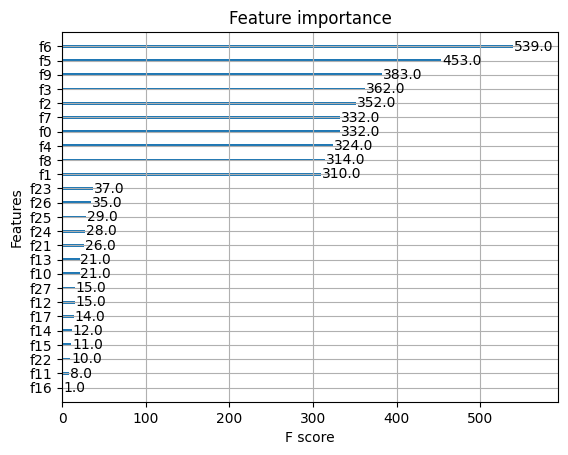

In [52]:
xgb.plot_importance(model)

In [53]:
yhat_probs = model.predict_proba(Xte, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [54]:
# with open(os.path.join(MODEL_DIR, 'xgb4_1_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'xgb4_1_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [55]:
models.append('xgb1')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost (xgb2)
by Hao Ting

In [56]:
model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb4_2.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

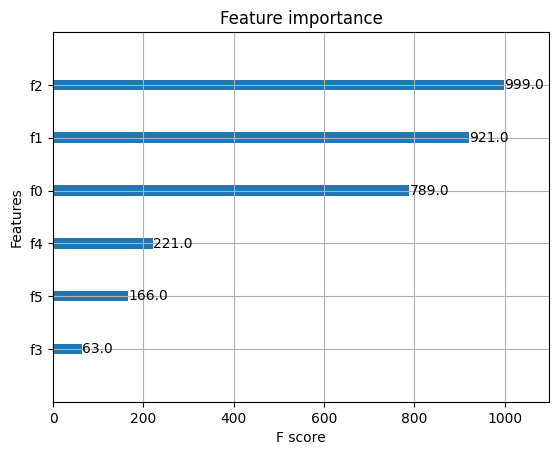

In [57]:
xgb.plot_importance(model)

In [58]:
## load data for xgb2
Xte2 = pd.read_csv('../data/xgb2_feature.csv')
yte2 = pd.read_csv('../data/xgb2_label.csv')

In [59]:
yhat_probs = model.predict_proba(Xte2, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte2, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [60]:
models.append('xgb2')
roc_aucs.append(roc_auc_score(yte2, yhat1_probs))
pr_aucs.append(average_precision_score(yte2, yhat))
precisions.append(precision_score(yte2, yhat))
recalls.append(recall_score(yte2, yhat))
f1s.append(f1_score(yte2, yhat))
roc_curves.append(roc_curve(yte2, yhat1_probs))
pr_curves.append(precision_recall_curve(yte2, yhat1_probs))

## XGBoost (xgb3)
by Samuel

In [61]:
model = XGBClassifier()  # init model
model_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models')
model.load_model(os.path.join(model_dir, 'xgb4_3.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

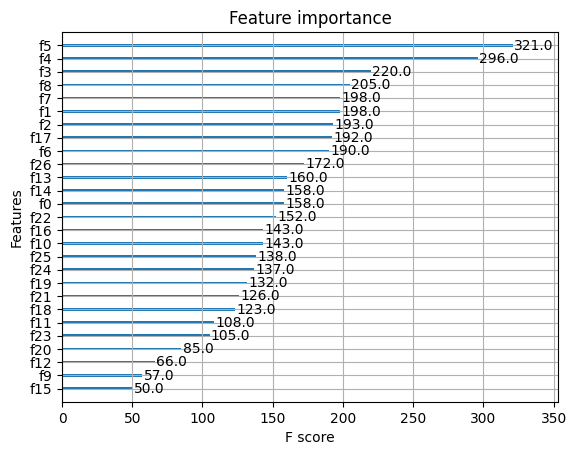

In [62]:
xgb.plot_importance(model)

In [63]:
## load data for xgb3
Xte3 = pd.read_csv('../data/xgb3_test_feature.csv')
yte3 = pd.read_csv('../data/xgb3_test_label.csv')

In [64]:
yhat_probs = model.predict_proba(Xte3, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte3, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [65]:
models.append('xgb3')
roc_aucs.append(roc_auc_score(yte3, yhat1_probs))
pr_aucs.append(average_precision_score(yte3, yhat))
precisions.append(precision_score(yte3, yhat))
recalls.append(recall_score(yte3, yhat))
f1s.append(f1_score(yte3, yhat))
roc_curves.append(roc_curve(yte3, yhat1_probs))
pr_curves.append(precision_recall_curve(yte3, yhat1_probs))

## XGBoost (xgb4)
by Samuel

In [66]:
class SumRule:
  import numpy
  import scipy
  
  def __init__(self, model):
    self.model = model

  def sum_rule(self, y_instance_proba, pos_prior, neg_prior):
    n_instances = len(y_instance_proba)
    p_neg = (1 - n_instances) * (neg_prior) + self.numpy.sum(y_instance_proba[:, 0])
    p_pos = (1 - n_instances) * (pos_prior) + self.numpy.sum(y_instance_proba[:, 1])

    return self.scipy.special.softmax(self.numpy.array([p_neg, p_pos]) / (p_neg + p_pos))


  def predict(self, features, bag_indices, pos_prior=0.044936719250151844, neg_prior=0.9550632807498481):
    instance_proba = self.model.predict_proba(features)
    predictions = []

    for start, end in bag_indices:
      proba = self.sum_rule(instance_proba[start:end], pos_prior, neg_prior)
      predictions.append(int(proba[1] > proba[0]))

    return self.numpy.array(predictions)

  def predict_proba(self, features, bag_indices, pos_prior=0.044936719250151844, neg_prior=0.9550632807498481):
    instance_proba = self.model.predict_proba(features)
    bag_proba = []

    for start, end in bag_indices:
      proba = self.sum_rule(instance_proba[start:end], pos_prior, neg_prior)
      bag_proba.append(proba[1])

    return self.numpy.array(bag_proba)

In [67]:
import pandas as pd
import pickle
from xgboost import XGBClassifier

data_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/data')
model_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/models')
features = pd.read_csv(os.path.join(data_dir, 'sum_rule_test_feature.csv'))

with open(os.path.join(data_dir, 'test_bag_indices.pickle'), 'rb') as f:
  bag_indices = pickle.load(f)

with open(os.path.join(data_dir, 'test_bag_labels.pickle'), 'rb') as f:
  bag_labels = pickle.load(f)

model = XGBClassifier()
model.load_model(os.path.join(model_dir, 'sum_rule_xgb.model'))

In [74]:
yte4 = bag_labels

In [68]:
sum_rule_model = SumRule(model)

yhat = sum_rule_model.predict(features, bag_indices)
yhat1_probs = sum_rule_model.predict_proba(features, bag_indices)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

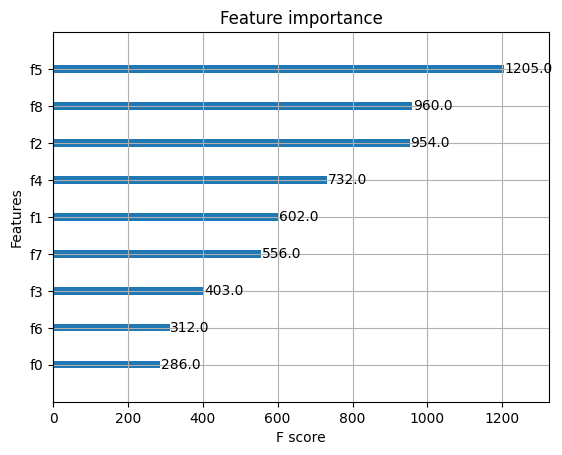

In [69]:
xgb.plot_importance(model)

In [75]:
models.append('xgb4')
roc_aucs.append(roc_auc_score(yte4, yhat1_probs))
pr_aucs.append(average_precision_score(yte4, yhat))
precisions.append(precision_score(yte4, yhat))
recalls.append(recall_score(yte4, yhat))
f1s.append(f1_score(yte4, yhat))
roc_curves.append(roc_curve(yte4, yhat1_probs))
pr_curves.append(precision_recall_curve(yte4, yhat1_probs))

## XGBoost (xgb5)
by Hans

In [76]:
# prepare data
df = pd.read_csv(os.path.join(DATA_DIR, "df2_no_duplicates.csv"))
df['transcript_position'] = df['transcript_position'].astype(str)
df2 = df.groupby(by = ['gene_id', 'transcript_id', 'transcript_position', 'nucleotides']).mean()
df2.reset_index(inplace=True)

df_tr = df2.loc[df2['gene_id'].isin(gtr)]
df_te = df2.loc[df2['gene_id'].isin(gte)]

Xtr5 = df_tr[['0', '1', '2', '3', '4', '5', '6', '7', '8']]
ytr5 = df_tr['label']
Xte5 = df_te[['0', '1', '2', '3', '4', '5', '6', '7', '8']]
yte5 = df_te['label']

In [77]:
# from collections import Counter

# # count examples in each class
# count_label = Counter(ytr5)
# # estimate scale_pos_weight value
# estimate = count_label[0] / count_label[1]
# print('Estimate: %.3f' % estimate)

In [78]:
# from math import ceil

# model = XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight = ceil(estimate),
#     max_delta_step=1,
#     seed=42,
#     verbosity=1
# )

In [79]:
# model.fit(Xtr5, ytr5)

In [80]:
# model.save_model(os.path.join(MODEL_DIR, 'xgb4_5.model'))

In [81]:
model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb4_5.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

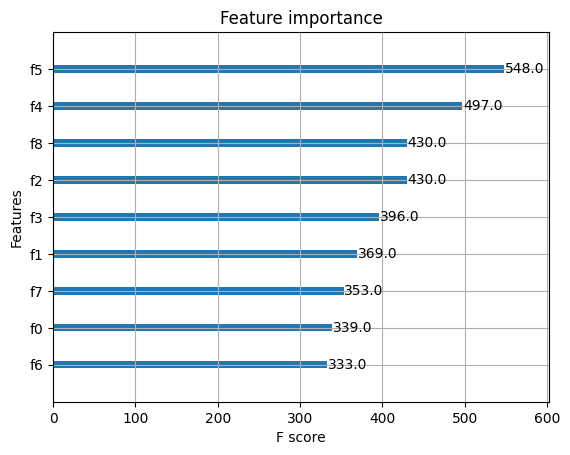

In [82]:
xgb.plot_importance(model)

In [83]:
yhat_probs = model.predict_proba(Xte5, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte5, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [84]:
# with open(os.path.join(MODEL_DIR, 'xgb4_5_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'xgb4_5_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [85]:
models.append('xgb5')
roc_aucs.append(roc_auc_score(yte5, yhat1_probs))
pr_aucs.append(average_precision_score(yte5, yhat))
precisions.append(precision_score(yte5, yhat))
recalls.append(recall_score(yte5, yhat))
f1s.append(f1_score(yte5, yhat))
roc_curves.append(roc_curve(yte5, yhat1_probs))
pr_curves.append(precision_recall_curve(yte5, yhat1_probs))

## Evaluate models

nb
---------------------
ROC AUC       = 0.799
PR AUC        = 0.106
Precision     = 0.185
Recall        = 0.420
F1            = 0.257
mean(ROC, PR) = 0.452
knn
---------------------
ROC AUC       = 0.679
PR AUC        = 0.127
Precision     = 0.410
Recall        = 0.217
F1            = 0.284
mean(ROC, PR) = 0.403
lsvc
---------------------
ROC AUC       = 0.774
PR AUC        = 0.048
Precision     = 0.000
Recall        = 0.000
F1            = 0.000
mean(ROC, PR) = 0.411
lda
---------------------
ROC AUC       = 0.844
PR AUC        = 0.227
Precision     = 0.506
Recall        = 0.391
F1            = 0.441
mean(ROC, PR) = 0.536
qda
---------------------
ROC AUC       = 0.771
PR AUC        = 0.094
Precision     = 0.134
Recall        = 0.531
F1            = 0.213
mean(ROC, PR) = 0.432
xgb1
---------------------
ROC AUC       = 0.867
PR AUC        = 0.186
Precision     = 0.258
Recall        = 0.657
F1            = 0.370
mean(ROC, PR) = 0.526
xgb2
---------------------
ROC AUC       = 0.850
PR

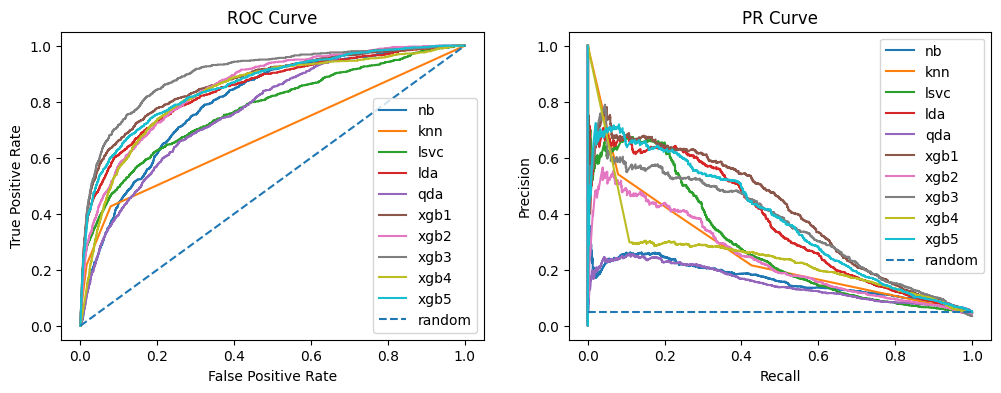

In [86]:
plt.figure(figsize=(12, 4))
random_yhat_probs = np.zeros(len(yte))
random_fpr, random_tpr, _ = roc_curve(yte, random_yhat_probs)

# relevant metrics
# roc_auc_score(yte, yhat1_probs)
# average_precision_score(yte, yhat)
# precision_score(yte, yhat)
# recall_score(yte, yhat)
# f1_score(yte, yhat)
# roc_curve(yte, yhat1_probs)
# precision_recall_curve(yte, yhat1_probs)

for _model, _roc_auc, _pr_auc, _precision, _recall, _f1, _roc_curve, _pr_curve in zip(models, roc_aucs, pr_aucs, precisions, recalls, f1s, roc_curves, pr_curves):
    print('=====================')
    print(_model)
    print('---------------------')
    print(f'ROC AUC       = {_roc_auc:.3f}')
    print(f'PR AUC        = {_pr_auc:.3f}')
    print(f'Precision     = {_precision:.3f}')
    print(f'Recall        = {_recall:.3f}')
    print(f'F1            = {_f1:.3f}')
    print(f'mean(ROC, PR) = {np.mean([_roc_auc, _pr_auc]):.3f}')

    # ROC
    fpr, tpr, _ = _roc_curve

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=_model)

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    precision, recall, _ = _pr_curve

    plt.subplot(1, 2, 2)
    no_skill = len(yte[yte==1]) / len(yte)
    plt.plot(recall, precision, label=_model)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

plt.subplot(1, 2, 1)
plt.plot(random_fpr, random_tpr, linestyle='--', label='random')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ROC AUC')

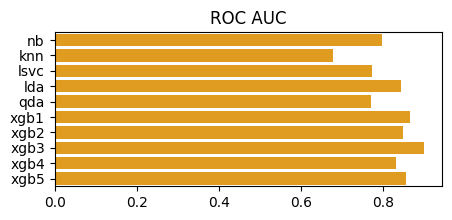

In [87]:
plt.figure(figsize=(5,2))
sns.barplot(x=roc_aucs, y=models, orient='h', color='orange')
plt.title("ROC AUC")

Text(0.5, 1.0, 'PR AUC')

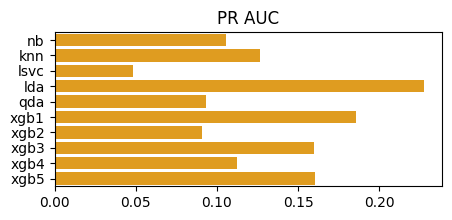

In [88]:
plt.figure(figsize=(5,2))
sns.barplot(x=pr_aucs, y=models, orient='h', color='orange')
plt.title("PR AUC")

Text(0.5, 1.0, 'Mean of ROC & PR AUC')

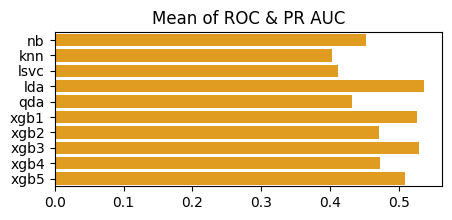

In [89]:
plt.figure(figsize=(5,2))
sns.barplot(x=np.mean([roc_aucs, pr_aucs], axis=0), y=models, orient='h', color='orange')
plt.title("Mean of ROC & PR AUC")

Text(0.5, 1.0, 'Precision')

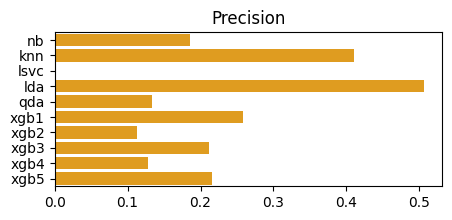

In [90]:
plt.figure(figsize=(5,2))
sns.barplot(x=precisions, y=models, orient='h', color='orange')
plt.title("Precision")

Text(0.5, 1.0, 'Recall')

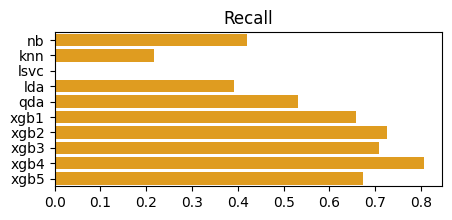

In [91]:
plt.figure(figsize=(5,2))
sns.barplot(x=recalls, y=models, orient='h', color='orange')
plt.title("Recall")

Text(0.5, 1.0, 'F1')

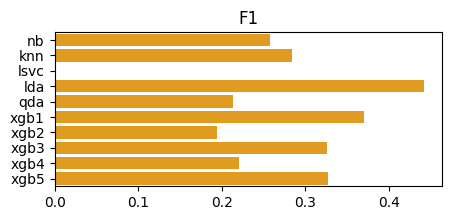

In [92]:
plt.figure(figsize=(5,2))
sns.barplot(x=f1s, y=models, orient='h', color='orange')
plt.title("F1")